In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

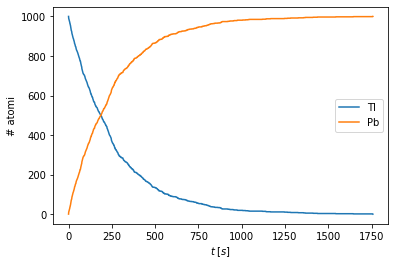

In [3]:
Tl = 1000
Pb = 0
Tl_list = [Tl]
Pb_list = [Pb]
tau = 3.052*60
p = 1-2**(-1/tau)
while Tl > 0:
    count = 0
    for i in range(Tl):
        r = np.random.rand()
        if r < p:
            count += 1
    Tl -= count
    Pb += count
    Tl_list.append(Tl)
    Pb_list.append(Pb)
t = range(len(Tl_list))
fig, ax = plt.subplots()
ax.plot(t, Tl_list, label = 'Tl')
ax.plot(t, Pb_list, label = 'Pb')
ax.set_xlabel('$t\;[s]$')
ax.set_ylabel('# atomi')
ax.legend()
plt.show()

In [4]:
def icdf(x, tau):
    return -tau*np.log(1-x)/np.log(2)

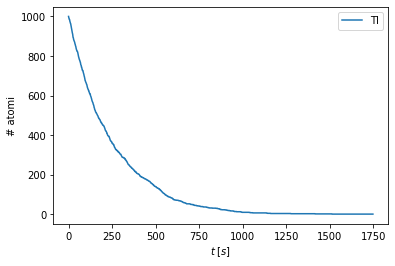

In [5]:
x = np.random.rand(1000)
T = icdf(x, tau)
t = range(1750)
y = [T[T>i].shape[0] for i in t]
fig, ax = plt.subplots()
plt.plot(t,y, label = 'Tl')
ax.set_xlabel('$t\;[s]$')
ax.set_ylabel('# atomi')
plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [6]:
a0 =  5.2917777210922e-11
sigma = a0/100
Cov = np.array([[sigma**2, 0],
                [0, sigma**2]])
X = np.random.multivariate_normal(mean = np.zeros(2), cov = Cov, size = (1000000))
Z = 79
e = 1.602176634e-19
E = 7.7e6
b = (X[:,0]**2+X[:,1]**2)**0.5
e0 = 8.8544e-12
theta = 2*np.arctan(Z*e/(2*np.pi*e0*E*b))
frac = theta[theta > np.pi/2].shape[0]/theta.shape[0]
print(frac)

0.001533


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [7]:
def func(x):
    return (np.sin(1/(x*(x-2))))**2

In [9]:
#True value
x=np.linspace(0.000001,1.999999,1000000)
y=func(x)
I_true = trapz(y,x)
print(I_true)

1.4513562580968504


In [24]:
N = int(1e6)
count = 0
for i in range(N):
    x = 2*np.random.rand()
    y = np.random.rand()
    if y<func(x):
        count+=1
I = count/N*2
print(I)
err = np.abs(I-I_true)
print('error = %.4f' %err)
r_err = 100*np.abs(I-I_true)/I_true
print('relative error = %.3f %%' % r_err)

1.451124
error = 0.0002
relative error = 0.016 %


In [25]:
N = int(1e6)
x = 2*np.random.rand(N)
y = func(x)
I = 2/N * np.sum(y)
print(I)
err = np.abs(I-I_true)
print('error = %.4f' %err)
r_err = 100*np.abs(I-I_true)/I_true
print('relative error = %.3f %%' % r_err)

1.4505857992592475
error = 0.0008
relative error = 0.053 %


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [10]:
N = int(1e6)
count = 0
for i in range(N):
    X = np.random.rand(2)
    if np.linalg.norm(X) <= 1:
        count += 1
I = 4*count/N
print(I)

3.139412


In [11]:
N = int(1e6)
count = 0
D = 10  #Dimensions
for i in range(N):
    X = np.random.rand(D)
    if np.linalg.norm(X) <= 1:
        count += 1
I = 2**D * count/N  
print(I)

2.562048


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [15]:
def ifunc(x):
    return x**2

In [16]:
N = int(1e6)
x = np.random.rand(N)
y = ifunc(x)
I = 1/N*np.sum(1/(np.exp(y)+1))*2
print(I)

0.8387861061027075
